In [1]:
import sys 
sys.path.append("/home/karen/Documents/GitHub/Muscle_wasting/network")
sys.path.append("/home/karen/Documents/GitHub/Muscle_wasting/database_analysis")
sys.path.append("/home/karen/Documents/GitHub/Muscle_wasting/venv/lib/python3.10/site-packages")
sys.path.append("/home/karen/Documents/GitHub/Muscle_wasting/venv/lib/python3.10/site-packages/networkx")

In [2]:
cd /home/karen/Documents/GitHub/Muscle_wasting

/home/karen/Documents/GitHub/Muscle_wasting


# Analyzing the relevance of the mirnas

Now we saw with the filtered and whole network
Let's get the mirnas from the relevant PR score and then evaluate them on the whole network

In [10]:
import walking_network as wn
import network_processing as netpro

In [133]:
import importlib
importlib.reload(jf)

<module 'jupyter_functions' from '/home/karen/Documents/GitHub/Muscle_wasting/network/jupyter_functions.py'>

In [4]:
import networkx as nx

In [5]:
import pandas as pd
import numpy as np

In [6]:
import matplotlib.pyplot as plt

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


In [8]:
# Function to ensure all elements are integers
def plot_dotplot(df):
    def convert_to_int_list(lst):
        return [int(x) for x in lst]


    
    # Create new DataFrame for plotting
    plot_data = pd.DataFrame(index=df.index, columns=df.columns)
    size_data = pd.DataFrame(index=df.index, columns=df.columns)
    color_data = pd.DataFrame(index=df.index, columns=df.columns)
    
    for col in df.columns:
        for idx in df.index:
            int_list = convert_to_int_list(df.at[idx, col])
            size_data.at[idx, col] = len(int_list)
            color_data.at[idx, col] = sum(int_list)
    
    # Convert to long format for seaborn
    plot_data = pd.DataFrame({
        'Gene': np.repeat(df.index, df.shape[1]),
        'miRNA': np.tile(df.columns, df.shape[0]),
        'Paths': size_data.values.flatten(),
        'Influence': color_data.values.flatten()
    })
    
    # Define custom colormap
    cmap = LinearSegmentedColormap.from_list('custom', ['red', 'white', 'blue'])

    
    
    # Filter out rows where the size is 0
    plot_data = plot_data[plot_data['Paths'] > 0]

    colors = ['red', 'white', 'blue']
    n_mid = abs(min(plot_data['Influence'])) / (abs(min(plot_data['Influence'])) + abs(max(plot_data['Influence'])))
    nodes = [0, n_mid, 1]
    cmap = LinearSegmentedColormap.from_list('custom', list(zip(nodes, colors)))
    
    # Plot using seaborn
    n_genes = len(plot_data)
    print(n_genes)
    height_plot = min(655,int(n_genes*.21))
    sns.set(rc={'axes.facecolor':'lightgray'})
    fig, ax = plt.subplots(figsize=(15, height_plot))
    ax.grid(False)
    #plt.figure(figsize=(10, height_plot))
    scatter_plot = sns.scatterplot(data=plot_data, x='miRNA', y='Gene', size='Paths', hue='Influence', palette=cmap, sizes=(20, 200))
    scatter_plot.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

    
    # Get the first two and last y-tick positions.
    miny, nexty, *_, maxy = ax.get_yticks()
    
    # Compute half the y-tick interval (for example).
    eps = (nexty - miny) / 2  # <-- Your choice.
    
    # Adjust the limits.
    ax.set_ylim(maxy+eps, miny-eps)
    #plt.tight_layout()
    plt.show()

We are going to load a graph with the mirnas and with the cut of pagerank to only get relevant genes on the network, however we should do it for the full gone, since genes belonging to pathways may be discarted on this PR evaluation. 

In [17]:
whole_network = netpro.load_graph(f"network/Networks_pkl/complete_n_tf_mirnas__tf_network_cutoff_0.1.pkl")

In [18]:
pr_network = netpro.load_graph(f"network/Networks_pkl/complete_n_tf_mirnas__tf_network_cutoff_0.1.pkl")

In [118]:
pr_mirs = netpro.get_mirs(pr_network)


In [123]:
immune_genes = []
with open('/home/karen/Documents/phd/Resources/inmune_genes_symbol.txt', 'r') as file:
        # Read all lines and strip any trailing newlines
        immune_genes = [line.strip() for line in file]
immune_genes[3]

'ABAT'

In [134]:
immune_score_dic = {}
for mir in pr_mirs:
    targets = netpro.get_target_of_mir(whole_network, mir)
    immune_score  =  jf.get_immune_score_mirna(immune_genes, targets)
    immune_score_dic[mir]=immune_score


In [136]:
df_tmp = pd.DataFrame(list(immune_score_dic.items()), columns=['mirna', 'inmuneScore'])
df_tmp.to_csv('mirna_score_immune.csv', index=False)

In [19]:
steps=5

In [20]:
miR_nodes = [node for node in pr_network.nodes if node.startswith('hsa-miR')]
len(miR_nodes)

566

In [ ]:
miR_nodes

In [22]:
mirPaths={}
for mir in miR_nodes:
    p = wn.get_pathways(graph=whole_network, mirna=mir, n_distance=steps, sample_size=10)
    unique_set = set(tuple(lst) for lst in p)
    
    # Convert back to a list of lists
    unique_list = [list(tpl) for tpl in unique_set]
    mirPaths[mir]=unique_list


In [23]:
sub_graph= wn.join_paths(whole_network, mirPaths)
sub_graph

In [24]:
sub_graph = wn.join_paths(whole_network, mirPaths)

In [ ]:
sub_graph.nodes()

In [ ]:
nx.draw_networkx(sub_graph)
plt.show()

In [27]:
isolated_nodes = list(nx.isolates(sub_graph))

In [28]:
nx.is_frozen(sub_graph)

True

In [29]:
sub_network = sub_graph.copy()

In [30]:
sub_network.remove_nodes_from(isolated_nodes)


In [31]:
start_node = 'hsa-miR-21-5p'

In [32]:
pwd

'/home/karen/Documents/GitHub/Muscle_wasting'

In [34]:
netpro.save_graph(sub_network, 'network/sub_network_nodes_500_1.pkl')

In [45]:

for mir in mirPaths.keys():
    try:
        wn.start_mir_path(sub_network, mir)
    except KeyError as ke:
        print(ke)


'hsa-miR-211-3p'


In [ ]:
influences={}
for node_name in sub_network.nodes:
    node = sub_network.nodes[node_name]
    if 'influence' in node['data']:
        influence = node['data']['influence']
        if type(influence)== dict and 'hsa-' not in node['data']['name']:
            print(node['data']['name'], influence)
            influences[node['data']['name']]=influence


In [ ]:
influences

In [48]:
df = pd.DataFrame(influences)

In [49]:
df = df[df.index.isin(list(mirPaths.keys()))]
df = df.fillna("").apply(list)
df

,CYP7A1,RXRA,MFN2,FOXA3,HSF2,KCTD16,IFT88,MED1,TFPI2,FUT4,...,MATK,PGK1,BDNF,MCM5,BRCA1,E2F2,TNFSF13B,FATE1,BCL6,HDAC2
hsa-miR-21-5p,"[1, 1, -1, 1]","[-1, -1]",[1],[1],"[1, 1]",[-1],,"[1, 1, 1, 1]","[-1, 1, 1]",[1],...,[1],"[1, 1, 1]","[1, 1, 1, 1, 1, -1, 1, -1]","[-1, -1]","[-1, 1, -1, 1, -1, 1, 1, 1, 1, -1]",,"[1, 1, 1, 1, 1, 1, 1]","[1, 1]","[1, 1, -1, 1, -1, 1, -1]","[-1, 1, 1]"
hsa-miR-210-3p,"[1, 1, 1, -1]","[-1, -1]",[1],[-1],"[1, 1]",[-1],,"[1, 1, 1, 1]","[-1, -1, 1]",[-1],...,[1],"[1, 1, -1]","[-1, 1, 1, -1, 1, 1, -1, -1]","[-1, -1]","[-1, 1, 1, -1, 1, 1, -1, -1, -1, -1]",,"[-1, 1, -1, 1, 1, 1, 1]","[1, -1]","[-1, -1, 1, -1, 1, -1, -1]","[-1, 1, -1]"
hsa-miR-145-5p,"[-1, -1, -1, 1]","[1, 1]",[-1],[-1],"[-1, -1]",[1],,"[-1, -1, -1, -1]","[-1, 1, -1]",[-1],...,[-1],"[1, -1, -1]","[-1, 1, -1, -1, -1, -1, 1, -1]","[1, -1]","[-1, 1, -1, 1, -1, 1, -1, -1, -1, -1]",,"[1, -1, -1, -1, -1, -1, -1]","[-1, 1]","[-1, -1, 1, 1, 1, -1, -1]","[-1, -1, 1]"
hsa-miR-143-3p,"[-1, -1, -1, 1]","[1, 1]",[-1],[-1],"[-1, -1]",[1],,"[-1, -1, -1, -1]","[-1, 1, -1]",[-1],...,[-1],"[1, -1, -1]","[-1, 1, -1, -1, -1, -1, 1, -1]","[1, -1]","[-1, -1, 1, -1, 1, -1, -1, -1, -1, -1]",,"[1, -1, -1, -1, -1, -1, -1]","[-1, -1]","[-1, -1, 1, 1, 1, -1, -1]","[1, -1, -1]"
hsa-miR-122-5p,[-1],,,,,,,,,,...,,,[1],,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsa-miR-3064-5p,,,,,,,,,,,...,,,,,,,,,,
hsa-miR-645,,,,,,,,,,,...,,,,,,,,,,
hsa-miR-100-3p,,,,,,,,,,,...,,,,,,,,,,
hsa-miR-204-3p,,,,,,,,,,,...,,,,,,,,,,


In [50]:

df = df.T

In [51]:
df.shape

(673, 559)

In [41]:
pwd

'/home/karen/Documents/GitHub/Muscle_wasting'

In [52]:
df.T.to_csv(f"data/mirna_influence_559_mirnas_673_genes_impact.csv")

In [ ]:

plot_dotplot(df)

Get the up or down reluation


In [54]:
df[:3]

,hsa-miR-21-5p,hsa-miR-210-3p,hsa-miR-145-5p,hsa-miR-143-3p,hsa-miR-122-5p,hsa-miR-128-3p,hsa-miR-29a-3p,hsa-miR-29b-3p,hsa-miR-181b-5p,hsa-miR-203a-3p,...,hsa-miR-589-5p,hsa-miR-320c,hsa-miR-378b,hsa-miR-1266-5p,hsa-miR-1182,hsa-miR-3064-5p,hsa-miR-645,hsa-miR-100-3p,hsa-miR-204-3p,hsa-miR-488-5p
CYP7A1,"[1, 1, -1, 1]","[1, 1, 1, -1]","[-1, -1, -1, 1]","[-1, -1, -1, 1]",[-1],"[1, 1, 1, -1]","[-1, -1, -1, 1]","[-1, -1, -1, 1]","[1, -1, 1, -1]","[1, 1, 1, -1]",...,,,,,,,,,,
RXRA,"[-1, -1]","[-1, -1]","[1, 1]","[1, 1]",,"[-1, -1, -1]","[1, 1]","[1, 1]","[-1, -1]","[-1, -1]",...,,,,,,,,,,
MFN2,[1],[1],[-1],[-1],,[1],[-1],[-1],[1],[1],...,,,,,,,,,,


In [55]:
regulation_YO={}
up_regulation_YO={}
down_regulation_YO={}
for node_name in sub_network.nodes:
    node = sub_network.nodes[node_name]
    if 'yo' in node['data']:
        regulation = node['data']['yo']
        regulation_YO[node['data']['name']]=regulation
        if regulation>0:
            up_regulation_YO[node['data']['name']]=regulation
        elif regulation<0:
            down_regulation_YO[node['data']['name']]=regulation


In [56]:
df_de_yo = df[df.index.isin(regulation_YO.keys())]
df_down_yo = df[df.index.isin(down_regulation_YO.keys())]
df_up_yo = df[df.index.isin(up_regulation_YO.keys())]

# Influence of the microRNAS

See the influcne of the genes that are down regualted in Young respect to old, this means that they INCREASE WITH AGE.
Therefore, what we would like to see is more big red dots that means that the microRNA inhibits that gene.

In [ ]:
plot_dotplot(df_down_yo)

See the influcne of the genes that are up regualted in Young respect to old, this means that they DECREASED WITH AGE.
Therefore, what we would like to see is more big blue dots that means that the microRNA estimulate that gene.

In [ ]:
plot_dotplot(df_up_yo)

In [58]:
regulation_YM={}
up_regulation_YM={}
down_regulation_YM={}
for node_name in sub_network.nodes:
    node = sub_network.nodes[node_name]
    if 'ym' in node['data']:
        regulation = node['data']['ym']
        regulation_YM[node['data']['name']]=regulation
        if regulation>0:
            up_regulation_YM[node['data']['name']]=regulation
        elif regulation<0:
            down_regulation_YM[node['data']['name']]=regulation


In [59]:
df_de_ym = df[df.index.isin(regulation_YM.keys())]
df_down_ym = df[df.index.isin(down_regulation_YM.keys())]
df_up_ym = df[df.index.isin(up_regulation_YM.keys())]

In [60]:
df_down_ym

,hsa-miR-21-5p,hsa-miR-210-3p,hsa-miR-145-5p,hsa-miR-143-3p,hsa-miR-122-5p,hsa-miR-128-3p,hsa-miR-29a-3p,hsa-miR-29b-3p,hsa-miR-181b-5p,hsa-miR-203a-3p,...,hsa-miR-589-5p,hsa-miR-320c,hsa-miR-378b,hsa-miR-1266-5p,hsa-miR-1182,hsa-miR-3064-5p,hsa-miR-645,hsa-miR-100-3p,hsa-miR-204-3p,hsa-miR-488-5p
FUBP1,[1],[-1],[-1],[-1],,[-1],[-1],[-1],[1],[-1],...,,,,,,,,,,
IL3,"[-1, -1, -1, 1, -1, 1, 1, 1, 1, 1]","[-1, -1, 1, 1, 1, 1, 1, 1, -1, -1]","[1, 1, -1, 1, -1, -1, -1, -1, -1, -1]","[1, 1, -1, 1, -1, -1, -1, -1, -1, -1]",,"[-1, -1, 1, 1, 1, 1, 1, 1, -1, -1]","[1, 1, -1, 1, -1, -1, -1, -1, -1, -1]","[1, 1, -1, 1, -1, -1, -1, -1, -1, -1]","[-1, -1, -1, 1, 1, 1, 1, 1, 1, 1]","[-1, -1, 1, 1, 1, 1, 1, 1, -1, -1]",...,,,,,,,,,,
U2SURP,[1],[-1],[-1],[-1],,[-1],[-1],[-1],[1],[-1],...,,,,,,,,,,
JCHAIN,"[-1, 1]","[1, -1]","[-1, -1]","[-1, -1]",,"[1, -1]","[-1, -1]","[-1, -1]","[-1, 1]","[1, -1]",...,,,,,,,,,,
GLI1,,,,,,,,,,,...,,,,,,,,,,
BTG1,"[1, 1, 1, 1, 1]","[1, 1, 1, 1, -1]","[-1, -1, -1, -1, -1]","[-1, -1, -1, -1, -1]",,"[1, 1, 1, 1, -1]","[-1, -1, -1, -1, -1]","[-1, -1, -1, -1, -1]","[1, 1, 1, 1, 1]","[1, 1, 1, 1, -1]",...,,,,,,,,,,
FGFR3,"[-1, 1]","[1, 1]","[-1, -1]","[-1, -1]",,"[1, 1]","[-1, -1]","[-1, -1]","[-1, -1]","[1, 1]",...,,,,,,,,,,
PLAG1,,,,,,,,,,,...,,,,,,,,,,
DMD,[-1],[-1],[1],[1],,[-1],[1],[1],[-1],[-1],...,,,,,,,,,,
CD69,"[-1, 1, 1, 1, 1, 1]","[-1, 1, -1, 1, 1, 1]","[1, -1, -1, -1, -1, -1]","[1, -1, -1, -1, -1, -1]",,"[-1, 1, -1, 1, 1, 1]","[1, -1, -1, -1, -1, -1]","[1, -1, -1, -1, -1, -1]","[1, 1, 1, 1, 1, 1]","[-1, 1, -1, 1, 1, 1]",...,,,,,,,,,,


In [61]:
import jupyter_functions as jf

In [68]:
import importlib
importlib.reload(jf)

<module 'jupyter_functions' from '/home/karen/Documents/GitHub/Muscle_wasting/network/jupyter_functions.py'>

In [69]:
df_impact = jf.get_impact_data(df_down_ym)

In [77]:
column_sums = df_impact.sum()

In [78]:
df_impact.loc[:, column_sums != 0]


,hsa-miR-21-5p,hsa-miR-210-3p,hsa-miR-145-5p,hsa-miR-143-3p,hsa-miR-128-3p,hsa-miR-29a-3p,hsa-miR-29b-3p,hsa-miR-181b-5p,hsa-miR-203a-3p,hsa-miR-29c-3p,...,hsa-miR-4775,hsa-miR-599,hsa-miR-450a-5p,hsa-miR-200c-5p,hsa-miR-378a-3p,hsa-miR-202-3p,hsa-miR-100-5p,hsa-miR-133b,hsa-miR-99a-5p,hsa-miR-338-5p
FUBP1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,1,-1,0,0,0,0,0,0
IL3,2,2,-4,-4,2,-4,-4,4,2,-4,...,-4,-4,8,2,0,0,0,0,0,0
U2SURP,1,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,1,-1,0,0,0,0,0,0
JCHAIN,0,0,-2,-2,0,-2,-2,0,0,-2,...,-2,-2,0,0,0,0,0,0,0,0
GLI1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-1,-1,0,-1,0,0
BTG1,5,3,-5,-5,3,-5,-5,5,3,-5,...,-5,-5,5,3,0,0,0,0,0,0
FGFR3,0,2,-2,-2,2,-2,-2,-2,2,-2,...,-2,-2,-2,2,0,0,-1,0,-1,0
PLAG1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DMD,-1,-1,1,1,-1,1,1,-1,-1,1,...,1,1,1,-1,0,0,0,0,0,0
CD69,4,2,-4,-4,2,-4,-4,6,2,-4,...,-4,-4,6,2,0,0,0,0,0,0


Down regulated in young respect of middle age

In [ ]:
plot_dotplot(df_down_ym)

genes 12
mirnas 20


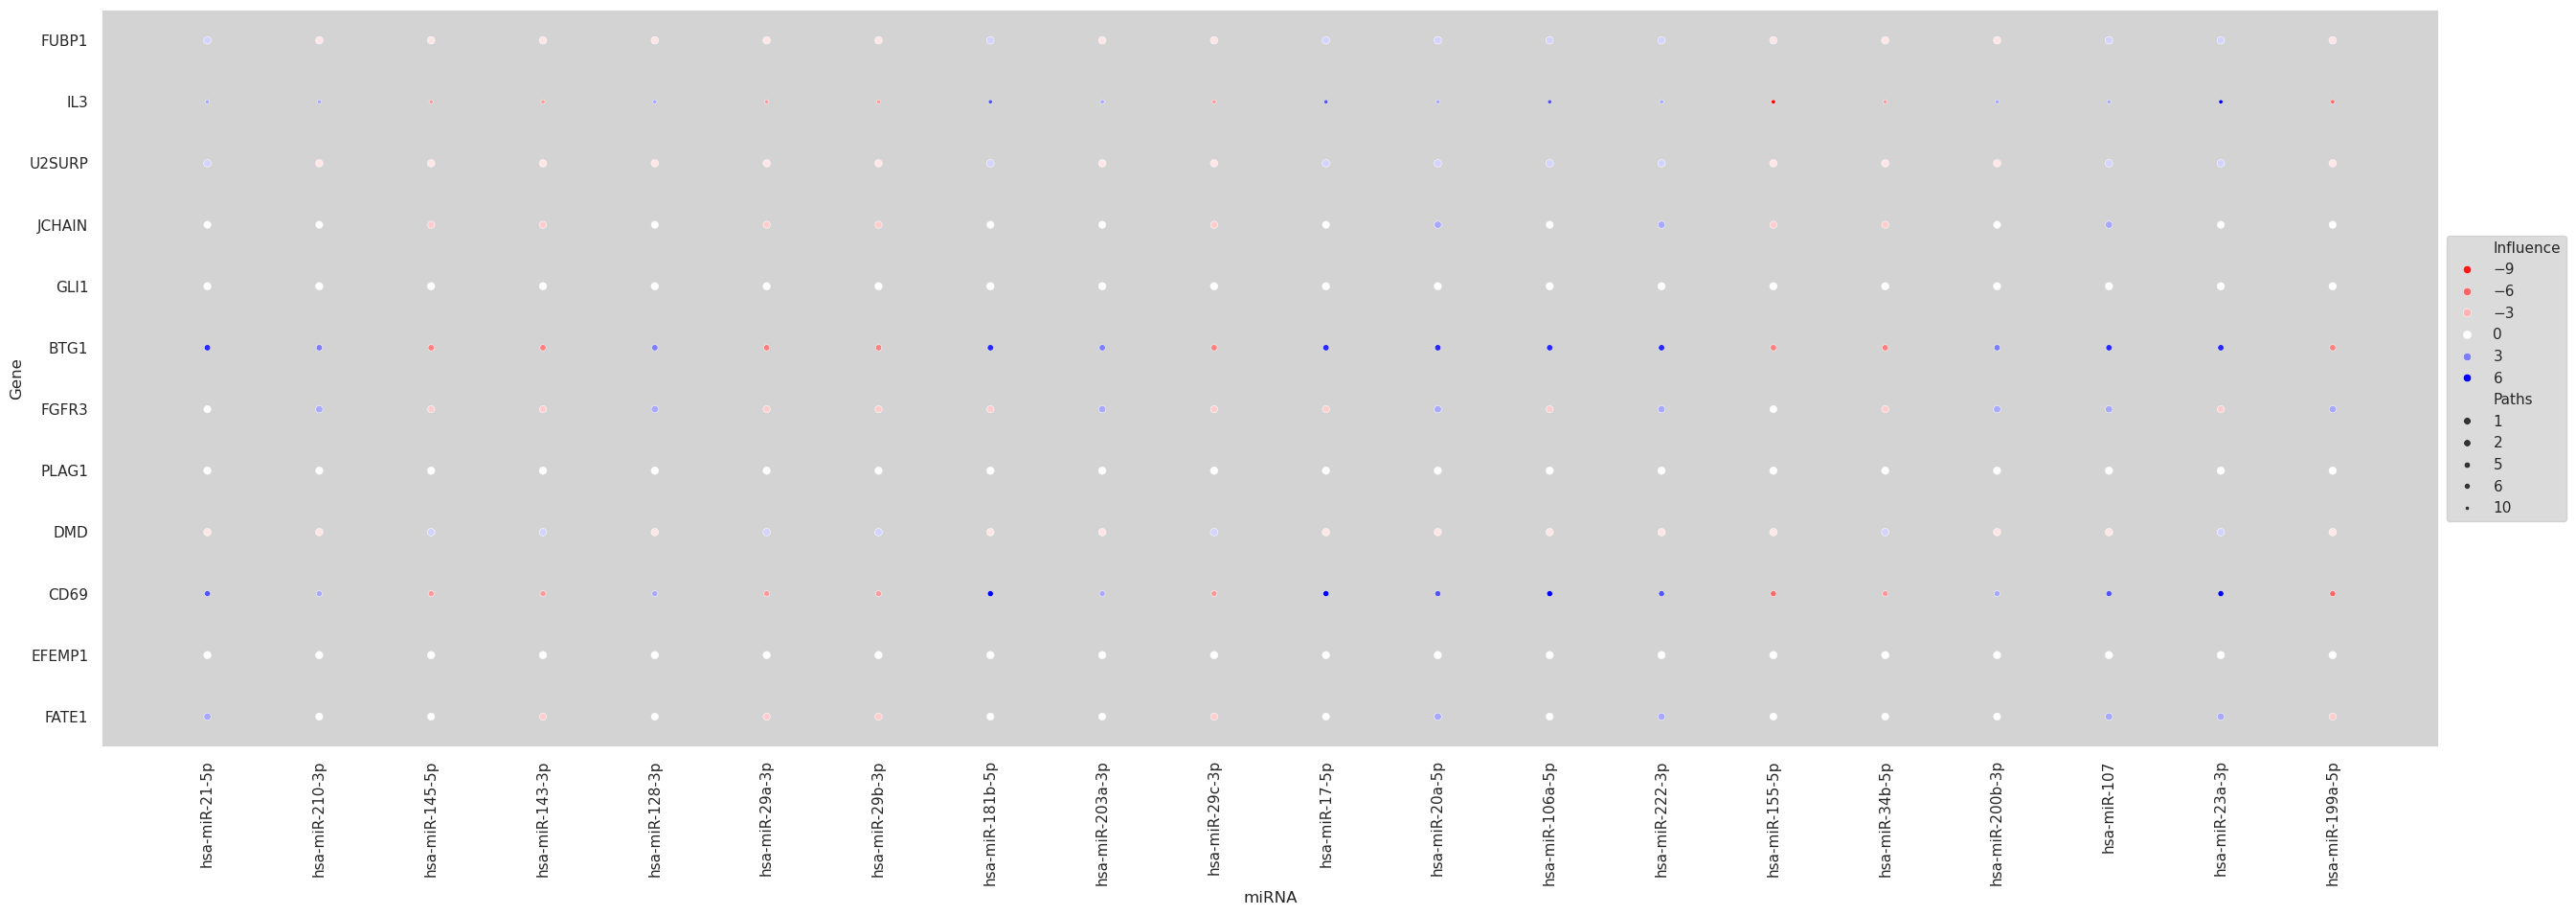

In [92]:
jf.plot_dotplot(df_down_ym.loc[:, column_sums != 0].iloc[:, :20], gene_scale=0.5)

Up regulated in young respect of middle age

In [ ]:
#plot_dotplot(df_up_ym)
df_up_ym

In [93]:
regulation_MO={}
up_regulation_MO={}
down_regulation_MO={}
for node_name in sub_network.nodes:
    node = sub_network.nodes[node_name]
    if 'mo' in node['data']:
        regulation = node['data']['mo']
        regulation_MO[node['data']['name']]=regulation
        if regulation>0:
            up_regulation_MO[node['data']['name']]=regulation
        elif regulation<0:
            down_regulation_MO[node['data']['name']]=regulation



In [94]:
df_down_mo = df[df.index.isin(down_regulation_MO.keys())]
df_up_mo = df[df.index.isin(up_regulation_MO.keys())]


These are the genes down regulated in middle age vs Old, this is the genes that increase with age.

In [ ]:
plot_dotplot(df_down_mo)

These are the genes up regulated in middle age vs Old, this is the genes that decrease with age.

In [96]:
mirInfluence={}
for mir, path in mirPaths.items():
    influence = wn.get_influence(whole_network, path)
    mirInfluence[mir]=influence
#mirInfluence

In [97]:
mir_pathway_influence = {}
for mir, influence_data in  mirInfluence.items():
    pi = wn.evaluate_pathway_influence(influence_data)
    mir_pathway_influence[mir]=pi

mir_de_influence = {}
for mir, influence_data in  mirInfluence.items():
    pi = wn.evaluate_de_influence(influence_data)
    mir_de_influence[mir]=pi


In [98]:
mir_pathway_influence_df = pd.DataFrame(mir_pathway_influence).T
#mir_pathway_influence_df = mir_pathway_influence_df.drop(columns=["Different_pathways", "Total"])
mir_pathway_influence_df['participation'] = mir_pathway_influence_df.drop(columns=["Different_pathways", "Total"]).sum(axis=1)
mir_pathway_influence_df

,ATP,MITOCHONDRI,RESPIRAT,METABOLI,OXIDATIVE_PHOSPHORYLATION,NONALCOHOLIC_FATTY_LIVER,MUSCLE,ELECTRON,Different_pathways,Total,participation
hsa-miR-223,0,0,0,0,0,0,0,0,0,0,0
hsa-miR-21-5p,1,4,4,5,2,3,1,0,20,232,20
hsa-miR-210-3p,0,0,0,0,0,1,0,0,3,40,1
hsa-miR-122,0,0,0,0,0,0,0,0,0,0,0
hsa-miR-145-5p,0,1,0,0,0,1,0,0,6,72,2
...,...,...,...,...,...,...,...,...,...,...,...
hsa-miR-1283,0,0,0,0,0,1,0,0,2,16,1
hsa-miR-335-3p,0,0,0,0,0,0,0,0,0,0,0
hsa-miR-195-3p,0,0,0,0,0,0,0,0,0,0,0
hsa-miR-204-3p,0,0,0,0,0,0,0,0,0,0,0


In [99]:
mean_influence  = mir_pathway_influence_df.loc[:, 'MITOCHONDRI'].mean()
mean_influence

0.5954063604240283

In [100]:
mitocondrial_df = mir_pathway_influence_df[mir_pathway_influence_df['MITOCHONDRI']>mean_influence].sort_values('MITOCHONDRI', ascending=False)
mitocondrial_df['Rate']=mir_pathway_influence_df['MITOCHONDRI']/mir_pathway_influence_df['participation']


In [101]:
mitocondrial_df[mitocondrial_df['Different_pathways']<10].sort_values('MUSCLE',ascending=False)

,ATP,MITOCHONDRI,RESPIRAT,METABOLI,OXIDATIVE_PHOSPHORYLATION,NONALCOHOLIC_FATTY_LIVER,MUSCLE,ELECTRON,Different_pathways,Total,participation,Rate
hsa-miR-296-3p,0,1,0,0,0,2,3,0,9,104,6,0.166667
hsa-miR-218-5p,1,2,0,3,0,2,2,0,9,96,10,0.200000
hsa-miR-99b-5p,0,1,0,2,0,3,2,0,8,104,8,0.125000
hsa-miR-143-3p,0,2,0,0,0,0,2,0,3,48,4,0.500000
hsa-miR-181b-5p,0,1,1,1,0,1,1,1,8,64,6,0.166667
hsa-miR-29b-3p,0,2,0,2,0,0,1,0,5,88,5,0.400000
hsa-miR-124-3p,0,1,1,0,0,0,1,1,6,64,4,0.250000
hsa-miR-27b-3p,0,1,0,0,0,0,1,0,4,32,2,0.500000
hsa-miR-30c-5p,0,1,0,0,0,0,1,0,2,16,2,0.500000
hsa-miR-433-3p,0,1,0,0,0,1,1,0,8,64,3,0.333333


In [102]:
mir_de_influence_df = pd.DataFrame(mir_de_influence).T


In [103]:
mir_de_influence_df[mir_de_influence_df['yo']>0]

,m_l,m_s,yo,ym,mo
hsa-miR-21-5p,0,0,8,1,1
hsa-miR-210-3p,0,0,5,0,1
hsa-miR-145-5p,0,0,6,0,1
hsa-miR-224-5p,0,0,1,0,0
hsa-miR-93-5p,0,0,2,0,0
...,...,...,...,...,...
hsa-miR-515-5p,0,0,1,0,0
hsa-miR-301b-5p,0,0,1,0,1
hsa-miR-922,0,0,1,0,0
hsa-miR-144-5p,0,0,1,0,0


In [104]:
mir_de_influence_df[mir_de_influence_df['mo']>0]

,m_l,m_s,yo,ym,mo
hsa-miR-21-5p,0,0,8,1,1
hsa-miR-210-3p,0,0,5,0,1
hsa-miR-145-5p,0,0,6,0,1
hsa-miR-122-5p,0,0,5,1,1
hsa-miR-128-3p,0,0,8,0,2
...,...,...,...,...,...
hsa-miR-599,0,0,10,0,10
hsa-miR-200b-5p,0,0,1,0,1
hsa-miR-219a-1-3p,0,0,1,1,1
hsa-miR-450a-5p,0,0,6,2,3


In [105]:
mirs_all_infliences = mir_de_influence_df[(mir_de_influence_df['ym']>0)|(mir_de_influence_df['mo']>0)|(mir_de_influence_df['yo']>0)]
mirs_all_infliences

,m_l,m_s,yo,ym,mo
hsa-miR-21-5p,0,0,8,1,1
hsa-miR-210-3p,0,0,5,0,1
hsa-miR-145-5p,0,0,6,0,1
hsa-miR-224-5p,0,0,1,0,0
hsa-miR-93-5p,0,0,2,0,0
...,...,...,...,...,...
hsa-miR-515-5p,0,0,1,0,0
hsa-miR-301b-5p,0,0,1,0,1
hsa-miR-922,0,0,1,0,0
hsa-miR-144-5p,0,0,1,0,0


In [106]:
sel_mirs_list = list(mirs_all_infliences.index)
len(sel_mirs_list)

294

In [114]:
mirs_all_infliences['sum'] = mirs_all_infliences.sum(axis=1)
mirs_all_infliences = mirs_all_infliences.sort_values(by='sum', ascending=False)
mirs_all_infliences.drop(columns=['sum'])
mirs_all_infliences[:50]

/tmp/ipykernel_19096/476871255.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mirs_all_infliences['sum'] = mirs_all_infliences.sum(axis=1)


,m_l,m_s,yo,ym,mo,sum
hsa-miR-34b-5p,0,0,10,3,10,69
hsa-miR-99b-5p,0,0,10,10,3,69
hsa-miR-449c-5p,0,0,10,2,10,66
hsa-miR-451a,0,0,9,3,9,63
hsa-miR-561-3p,0,0,9,3,9,63
hsa-miR-320b,0,0,10,1,10,63
hsa-miR-599,0,0,10,0,10,60
hsa-miR-494-3p,0,0,10,0,10,60
hsa-miR-874-3p,0,0,9,1,9,57
hsa-miR-487b-3p,0,0,8,1,8,51


,m_l,m_s,yo,ym,mo,sum
hsa-miR-21-5p,0,0,8,1,1,20
hsa-miR-210-3p,0,0,5,0,1,12
hsa-miR-145-5p,0,0,6,0,1,14
hsa-miR-224-5p,0,0,1,0,0,2
hsa-miR-93-5p,0,0,2,0,0,4
hsa-miR-375,0,0,1,0,0,2
hsa-miR-143-3p,0,0,6,2,0,16
hsa-miR-122-5p,0,0,5,1,1,14
hsa-miR-15a-5p,0,0,1,0,0,2
hsa-miR-16-5p,0,0,1,0,0,2


In [107]:
mir_pathway_influence_df_filteres = mir_pathway_influence_df[mir_pathway_influence_df.index.isin(sel_mirs_list)]

In [108]:
mir_pathway_influence_df_filteres#[mir_pathway_influence_df_filteres['MUSCLE']>0].sort_values('MUSCLE')

,ATP,MITOCHONDRI,RESPIRAT,METABOLI,OXIDATIVE_PHOSPHORYLATION,NONALCOHOLIC_FATTY_LIVER,MUSCLE,ELECTRON,Different_pathways,Total,participation
hsa-miR-21-5p,1,4,4,5,2,3,1,0,20,232,20
hsa-miR-210-3p,0,0,0,0,0,1,0,0,3,40,1
hsa-miR-145-5p,0,1,0,0,0,1,0,0,6,72,2
hsa-miR-224-5p,0,0,0,0,0,1,0,0,2,16,1
hsa-miR-93-5p,0,1,0,0,0,0,0,0,2,16,1
...,...,...,...,...,...,...,...,...,...,...,...
hsa-miR-515-5p,0,0,0,1,0,0,0,2,3,24,3
hsa-miR-301b-5p,0,0,0,0,0,0,0,0,1,8,0
hsa-miR-922,0,0,0,0,0,0,0,0,0,0,0
hsa-miR-144-5p,0,0,0,0,0,0,1,0,1,8,1


In [109]:
mirPaths['hsa-miR-21-5p']

[['hsa-miR-21-5p', 'DAXX', 'NR3C1', 'IL1B'],
 ['hsa-miR-21-5p', 'PPARA', 'APOB'],
 ['hsa-miR-21-5p', 'PPARA', 'STAT5A', 'ABL1', 'JUN'],
 ['hsa-miR-21-5p', 'IL1B'],
 ['hsa-miR-21-5p', 'PPIF'],
 ['hsa-miR-21-5p', 'MSH2'],
 ['hsa-miR-21-5p', 'DNM1L'],
 ['hsa-miR-21-5p', 'PPARA', 'ABCA12']]

In [110]:
mirPaths['hsa-miR-93-5p']

[['hsa-miR-93-5p', 'FOXO3'], ['hsa-miR-93-5p', 'VEGFA']]

In [ ]:
mirPaths